In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from google.colab import drive
from keras.models import model_from_yaml
import numpy
import os
drive.mount('/content/drive/')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
df = pd.read_csv('drive/My Drive/Tesis/Data/Flujo1.csv', sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
def enumerate_dimensions(dimension, list_dimensions): 
    return list_dimensions.index(dimension)
def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

In [0]:
# Se Construye Dataframe solo de medio ambiente
df = df[df.Area == 'Medio Ambiente']

# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)

#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary = list(set(vocabulary))

df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)
# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)

# Pasamos las dimensiones a np array
y_completo = np.array(df['_dimension'])

X, test_x, y, test_y = train_test_split(X_completo, y_completo, test_size = 0.1, random_state = 0)
resultados = []

In [7]:
#Celda de prueba
vocab_len= len(vocabulary)+1
num_classes = len(list_dimensions) #2
ouput_dim_embedding = 100
lstm_units = 90
ouputs_dense = 2
epoch = 5
batch_size = 45
optimizer = 'rmsprop'
model = tf.keras.Sequential()
#Se agrega capa embedding que hace w2v
model.add(tf.keras.layers.Embedding(input_dim=vocab_len, output_dim = ouput_dim_embedding, input_shape=(X_completo.shape[1],)))
model.add(tf.keras.layers.LSTM(units=lstm_units, activation='sigmoid', dropout=0.5, recurrent_dropout=0.5))
model.add(tf.keras.layers.Dense(units=num_classes, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
history = model.fit(X, y, epochs = epoch, batch_size=batch_size)
print()
print('Resultados con datos de testeo ')
print()
test_loss, test_acurracy = model.evaluate(test_x, test_y)
print()
print('Data Test accuracy: {}'.format(test_acurracy))
predictions = model.predict_classes(test_x)
resultados.append(test_acurracy)
#Matriz de confusion
confusion = tf.confusion_matrix(labels=test_y, predictions= predictions, dtype=tf.dtypes.int32, num_classes=num_classes)
print('-Matriz de confusion')
print(confusion.eval(session=tf.Session()))
resultados

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 11671 samples
Epoch 1/5
11671/11671 [==============================] - 8s 678us/sample - loss: 0.4263 - sparse_categorical_accuracy: 0.8352
Epoch 2/5
11671/11671 [==============================] - 7s 620us/sample - loss: 0.2834 - sparse_categorical_accuracy: 0.8824
Epoch 3/5
11671/11671 [==============================] - 7s 622us/sample - loss: 0.2484 - sparse_categorical_accuracy: 0.9006
Epoch 4/5
11671/11671 [==============================] - 7s 613us/sample - loss: 0.2316 - sparse_categorical_accuracy: 0.9075
Epoch 5/5
11671/11671 [==============================] - 7s 613us/sample - loss: 0.2201 - sparse_categorical_accuracy: 0.9147

Resultados con datos de testeo 

1297/1297 [=========

[0.8997687]

In [8]:
vocab_len= len(vocabulary)+1
num_classes = len(list_dimensions) #2
ouput_dim_embedding = 100
lstm_units = 90
ouputs_dense = 2
epoch = 5
batch_size = 45
optimizer = 'rmsprop'

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
resultados = []
contador = 1
for valores_entrenamiento, valores_testeo in kf.split(X):
    model = tf.keras.Sequential()
    #Se agrega capa embedding que hace w2v
    model.add(tf.keras.layers.Embedding(input_dim = vocab_len, output_dim = ouput_dim_embedding, input_shape=(X_completo.shape[1],)))
    model.add(tf.keras.layers.LSTM(units=lstm_units, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(units=ouputs_dense, activation='sigmoid'))
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    history = model.fit(X[valores_entrenamiento], y[valores_entrenamiento], epochs =epoch, batch_size=batch_size)
    
    print()
    print(contador, '-Resultados con datos de testeo ')
    print()
    test_loss, test_acurracy = model.evaluate(X[valores_testeo], y[valores_testeo])
    print()
    print(contador, '-Data Test accuracy: {}'.format(test_acurracy))
    resultados.append(test_acurracy)
    print()
    predictions = model.predict_classes(X[valores_testeo])
    #Matriz de confusion
    confusion = tf.confusion_matrix(labels=y[valores_testeo], predictions= predictions, dtype=tf.dtypes.int32, num_classes=num_classes)
    print(contador, '-Matriz de confusion')
    print(confusion.eval(session=tf.Session()))
    print()
    contador = contador + 1

Train on 10503 samples
Epoch 1/5
10503/10503 [==============================] - 6s 611us/sample - loss: 0.4041 - sparse_categorical_accuracy: 0.8428
Epoch 2/5
10503/10503 [==============================] - 6s 555us/sample - loss: 0.2575 - sparse_categorical_accuracy: 0.8979
Epoch 3/5
10503/10503 [==============================] - 6s 562us/sample - loss: 0.2307 - sparse_categorical_accuracy: 0.9067
Epoch 4/5
10503/10503 [==============================] - 6s 560us/sample - loss: 0.2174 - sparse_categorical_accuracy: 0.9157
Epoch 5/5
10503/10503 [==============================] - 6s 554us/sample - loss: 0.2064 - sparse_categorical_accuracy: 0.9194

1 -Resultados con datos de testeo 

1168/1168 [==============================] - 0s 219us/sample - loss: 0.2867 - sparse_categorical_accuracy: 0.8750

1 -Data Test accuracy: 0.875

1 -Matriz de confusion
[[166  59]
 [ 87 856]]

Train on 10504 samples
Epoch 1/5
10504/10504 [==============================] - 6s 611us/sample - loss: 0.4066 - spars

In [9]:
print(resultados)
print(np.array(resultados).mean())

[0.875, 0.9040274, 0.89203084, 0.9031705, 0.88860327, 0.88774633, 0.898886, 0.89802915, 0.898886, 0.8860326]
0.8932411


In [16]:
model_yaml = model.to_yaml()
with open("drive/My Drive/Tesis/RNN/MA/modelMA.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("drive/My Drive/Tesis/RNN/MA/modelMA.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
for i in range(len(predictions)):
    print('Para texto:', [vocabulary[item] for item in X[valores_testeo][i]])
    print('El valor Predicho es', predictions[i], 'Y deberia ser', y[valores_testeo][i])

Para texto: ['desplegar', 'reutiliad', 'recojerlos', 'basica', 'amigo', 'cuelga', 'llevar', 'llevar', 'llevar', 'llevar']
El valor Predicho es 1 Y deberia ser 1
Para texto: ['transitorio', 'ese', 'irrelevante', 'reutiliad', 'mercaderia', 'aelica', 'entorno', 'europeo', 'llevar', 'llevar']
El valor Predicho es 1 Y deberia ser 1
Para texto: ['actor', 'liquidar', 'adaptacion', 'universitario', 'liquidar', 'llevar', 'llevar', 'llevar', 'llevar', 'llevar']
El valor Predicho es 0 Y deberia ser 0
Para texto: ['organicos', 'coeficiente', 'forestacion', 'impresion', 'faenar', 'organicos', 'asiento', 'for', 'explicitarlas', 'llevar']
El valor Predicho es 0 Y deberia ser 1
Para texto: ['reo', 'empresa', 'retirarla', 'familiarizar', 'llevar', 'llevar', 'llevar', 'llevar', 'llevar', 'llevar']
El valor Predicho es 0 Y deberia ser 0
Para texto: ['inconsecuencia', 'aferrarse', 'amigo', 'favorecer', 'ropa', 'adoptarlas', 'aser', 'llevar', 'llevar', 'llevar']
El valor Predicho es 1 Y deberia ser 1
Para 

IndexError: ignored

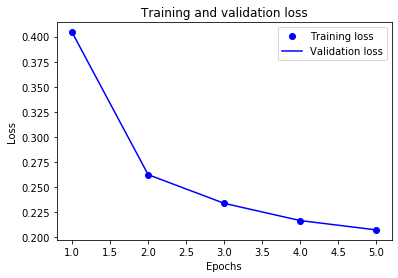

In [0]:
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['sparse_categorical_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

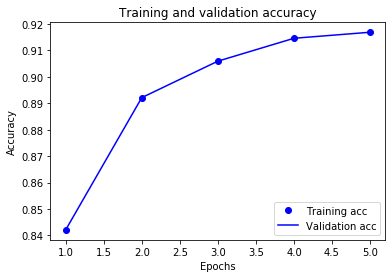

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

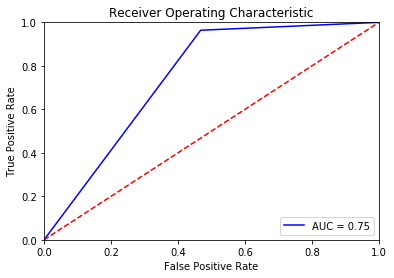

In [0]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y[valores_testeo], predictions)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()